In [1]:
# Install clip
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 71kB 8.9MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=1f3dba5442cdc7398f93eee4fc6a62500ffede64177210c665b188558089ff95
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2r2nwdkf
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-2r2nwdkf
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 12.8MB 271kB/s 
  Created wheel for clip: filename=clip-1.0-cp37-none-any.whl size=1368722 sha256=938b1b434e6f9d6aa31e66c5968b742e6c78b29f0e5754322c97eb0369665774
  Stored in directory: /tmp/pip-ephem-wheel-cache-0wezm58z/wheels/79/51/d7/69f91d37121befe21d9c52332e04f592e17d1cabc7319b3e09
Successfully built clip
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is

In [2]:
!nvidia-smi

Sun Jun 13 06:02:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from matplotlib import pyplot as plt
import clip
import torch
import torchvision
from torchvision import transforms
from torchvision.models import vgg19
from PIL import Image
import torch.optim as optim
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [4]:
# CLIP
model, _ = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 354M/354M [00:18<00:00, 19.5MiB/s]


In [5]:
# Prepare VGG 19 model
import torch.nn as nn
vgg = vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)
    
for i, layer in vgg.named_children():
    if isinstance(layer, torch.nn.MaxPool2d):
        vgg[int(i)] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

vgg.eval()
vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [6]:
# Content image
!curl -o content.jpg "https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/tubingen.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  397k  100  397k    0     0  3854k      0 --:--:-- --:--:-- --:--:-- 3854k


In [7]:
# Image transforms
IMG_SIZE=512

img_transforms = transforms.Compose([
  transforms.Resize(IMG_SIZE),
  transforms.CenterCrop(IMG_SIZE),
  transforms.ToTensor()
])

vgg_transforms = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

clip_img_transforms = transforms.Compose([
  transforms.Resize(size=224),  
  transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

In [8]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {"23": "conv4_3"}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [19]:
# a vincent van gough starry night style painting
# Wheatfield with Crows 
style_prompt="a vincent van gough starry night style painting"
criterion = [style_prompt]
text = clip.tokenize(criterion).to(device)

0 42.6047 | 0.0 | 0.874
100 104.6838 | 0.2947 | 0.5205
200 103.0178 | 0.2826 | 0.4946
300 102.4281 | 0.2837 | 0.4614
400 102.3755 | 0.2871 | 0.458
500 102.4207 | 0.2873 | 0.4736
600 101.9988 | 0.2846 | 0.4771
700 101.9933 | 0.2788 | 0.4634
800 101.8567 | 0.2796 | 0.4331
900 102.1544 | 0.2867 | 0.4814


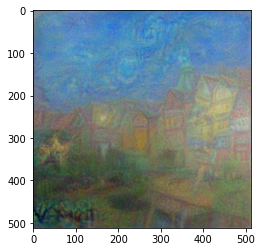

In [21]:
input_image = Image.open("content.jpg")
content_img = img_transforms(input_image).to(device)

content_features = get_features(vgg_transforms(content_img).unsqueeze(0), vgg)
target = content_img.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([target],lr=0.5)

def high_pass_x_y(image):
    x_deltas = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_deltas = image[:, :, :, 1:] - image[:, :, :, :-1]
    return x_deltas, y_deltas

def get_pil_image(img_tensor):
    img = img_tensor.clone().squeeze().cpu().detach().permute(1,2,0).numpy().clip(0,1)
    return Image.fromarray(np.uint8(img * 255))

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return torch.sum(torch.abs(x_deltas)) +torch.sum(torch.abs(y_deltas))

frame_count=0
for epoch in range(1000):
    content_weight= 1.5
    tv_weight =1e-3
    target_features = get_features(vgg_transforms(target).unsqueeze(0), vgg)
    
    # Content loss
    content_loss = torch.mean((target_features["conv4_3"] - content_features["conv4_3"]) ** 2)

    # TV loss
    tv_loss =total_variation_loss(target.unsqueeze(0))
    
    # CLIP loss
    logits=model(clip_img_transforms(target).unsqueeze(0), text)
    clip_loss=1-logits[0].sum()/100

    loss=content_loss * content_weight + clip_loss + tv_loss * tv_weight
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 :
        frame_count+=1
        print(epoch, round(loss.item(),4),"|",round(content_loss.item(),4),"|",round(clip_loss.item(),4))
        img=get_pil_image(target)
        image_name=f"{frame_count}.png"
        img.save(image_name)
        plt.imshow(img)
    

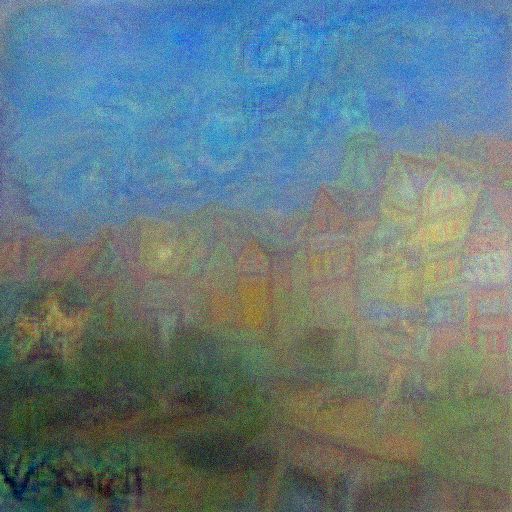

In [22]:
#Styled image
styled_image=Image.open(f"{frame_count}.png")
styled_image

In [23]:
from tqdm.notebook import tqdm
from base64 import b64encode
from IPython import display

min_fps = 10
max_fps = 30

total_frames = frame_count

length = 15 #Tiempo deseado del vídeo en segundos
frames=[]
for i in range(frame_count): #
    filename = f"{i+1}.png"
    frames.append(Image.open(filename))

fps = np.clip(frame_count/length,min_fps,max_fps)

from subprocess import Popen, PIPE
p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', 'video.mp4'], stdin=PIPE)
for im in tqdm(frames):
    im.save(p.stdin, 'PNG')
p.stdin.close()
p.wait()
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)